In [1]:
import pandas as pd
pd.set_option("display.max_column",101)

import numpy as np
np.random.seed(27042018)

from functools import partial

import sys

import datetime

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

import xgboost as xgb
import xgbfir
from xgboost import plot_tree

from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

from collections import defaultdict

from sklearn.metrics import make_scorer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel('../input/house.csv.xlsx', 'house.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null object
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null object
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(3), int64(15), object(3)
memory usage: 3.5+ MB


- There're **21613 rows** (objects)and **21 columns**
- `price` is target variable
- regression (predict continuous numbers)
- data required 3.5 mb 

## Missing data?

In [4]:
df.isnull().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

**There's no missing data**

## Sample of data

In [5]:
df.sample(15)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2949,7128300855,20141014T000000,313000.0,4,1.75,1630,3000,1,0,0,3,7,930,700,1978,0,98144,47.5961,-122.305,1630,3000
12074,4046600070,20140619T000000,805000.0,3,3,3910,19023,2,0,0,3,11,3910,0,1985,0,98014,47.6953,-121.914,1860,15001
17105,3275300050,20141124T000000,272000.0,3,3,2430,10500,1,0,0,4,8,2150,280,1983,0,98003,47.2579,-122.312,1670,9800
14603,2624049103,20150325T000000,449000.0,2,1,1250,4576,1,0,0,3,6,1040,210,1925,0,98118,47.5387,-122.266,1550,5000
8117,5649600266,20150224T000000,386000.0,3,2017-01-05 00:00:00,1550,8000,1,0,0,3,6,1330,220,1980,0,98118,47.5536,-122.286,1150,5150
283,7202360350,20140630T000000,780000.0,4,2017-02-05 00:00:00,3500,7048,2,0,0,3,9,3500,0,2005,0,98053,47.6811,-122.025,3920,7864
3876,3626039228,20140918T000000,408000.0,3,1,1380,7015,2017-01-05 00:00:00,0,0,4,7,1380,0,1925,0,98117,47.6987,-122.360,1160,6700
13380,3726800220,20150406T000000,348000.0,3,1.75,1830,2417,1,0,0,3,7,930,900,1919,0,98144,47.5723,-122.309,1320,3200
8743,6126601445,20140530T000000,490000.0,3,1.75,1920,5405,1,0,2,4,7,960,960,1947,0,98126,47.5583,-122.380,1190,5405
18558,4345300180,20150406T000000,269000.0,3,2,1410,10577,1,0,0,3,7,1410,0,1994,0,98030,47.3642,-122.187,1660,6757


## Convert date to `datetime`

In [6]:
df['date'] = pd.to_datetime( df['date'] )

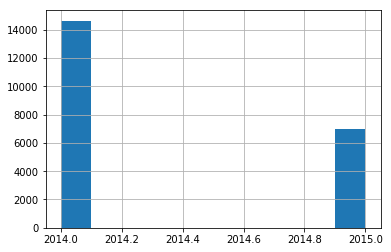

In [7]:
df['date'].dt.year.hist();

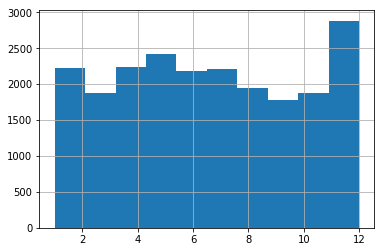

In [8]:
df['date'].dt.month.hist();

## price (target variable)

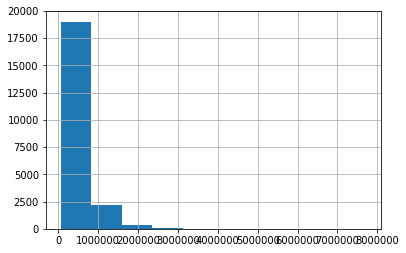

In [9]:
df['price'].hist();

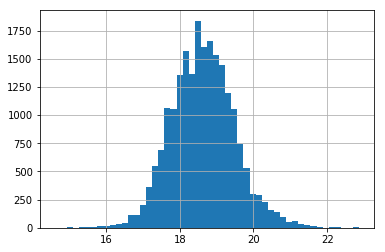

In [10]:
df['price_log'] = np.log2( df['price'] - 50000 )
df['price_log'].hist(bins=50);

`Feels like I need to achieve symetric decay, then I can expect model to be more stabile.`

## bedrooms

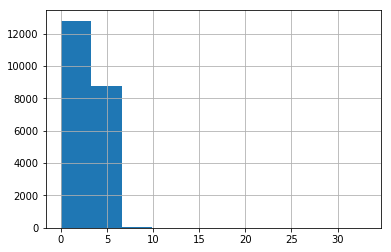

In [11]:
df['bedrooms'].hist();

In [12]:
df.shape

(21613, 22)

In [13]:
df = df[ df['bedrooms'] < 10 ]

In [14]:
df.shape

(21608, 22)

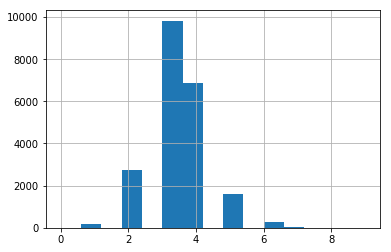

In [15]:
df['bedrooms'].hist(bins=15);

** There are only few flats with more than 10 bedrooms so I'm not going to include them in prediction. ** 

## bathrooms

In [16]:
df[ ['bathrooms'] ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21608 entries, 0 to 21612
Data columns (total 1 columns):
bathrooms    21608 non-null object
dtypes: object(1)
memory usage: 337.6+ KB


In [17]:
len('2017-02-25 00:00:00')

19

In [18]:
def parse_bathrooms(value):
    if isinstance(value, datetime.date): return -1
    if str(value) == 19: return -2 #unkonwn

#     if '.' in str(value): 
#         return -3 #area
    
    return float(value)
      

df['bathrooms_temp'] = df['bathrooms'].map( parse_bathrooms )

** I saw some noise in `bathrooms`. Decided to make a transformation, so I could get rid of it. ** 

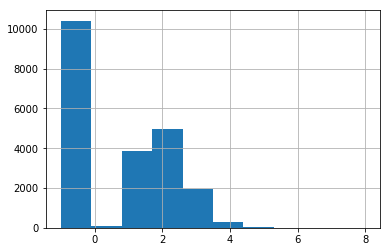

In [19]:
df['bathrooms_temp'].hist();

## sqft_living

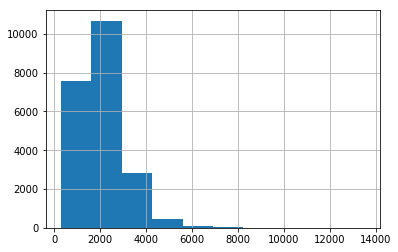

In [20]:
df['sqft_living'].hist();

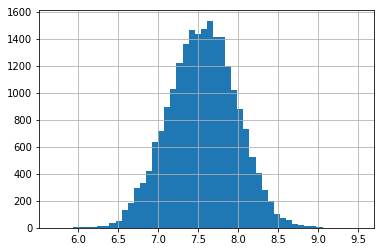

In [21]:
df['sqft_living_log'] = np.log( df['sqft_living'] + 10 )
df['sqft_living_log'].hist(bins=50);

## sqft_lot

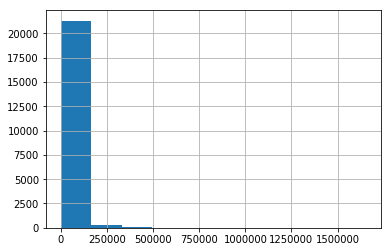

In [22]:
df['sqft_lot'].hist();

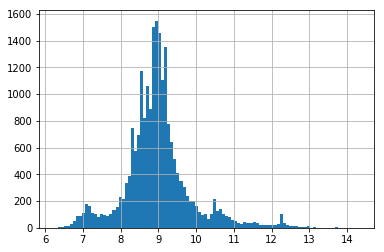

In [23]:
df['sqft_lot_log'] = np.log( df['sqft_lot'] )
df['sqft_lot_log'].hist(bins=100);

## floors

In [24]:
df['floors'].unique()

array([1, 2, datetime.datetime(2017, 1, 5, 0, 0), 3,
       datetime.datetime(2017, 2, 5, 0, 0),
       datetime.datetime(2017, 3, 5, 0, 0)], dtype=object)

In [25]:
df['floors'] = df['floors'].map( lambda x: -1 if isinstance(x, datetime.date) else int(x) )

In [26]:
df['floors'].unique()

array([ 1,  2, -1,  3])

**Taking care of noise in `floors`**

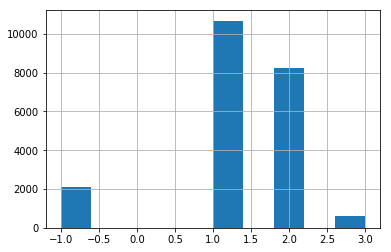

In [27]:
df['floors'].hist();

## waterfront

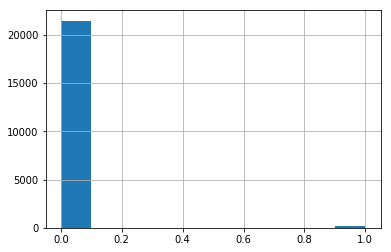

In [28]:
df['waterfront'].hist();

In [29]:
df['waterfront'].value_counts(normalize=True)

0    0.992456
1    0.007544
Name: waterfront, dtype: float64

** Majority of houses are not facing waterfront, seems like a luxury commodity **

## view

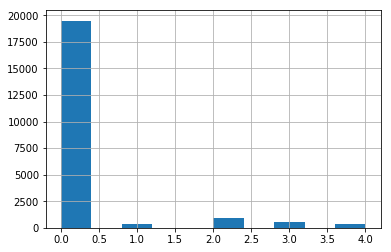

In [30]:
df['view'].hist();

In [31]:
df['view'].value_counts(normalize=True)

0    0.901749
2    0.044521
3    0.023602
1    0.015365
4    0.014763
Name: view, dtype: float64

## condition

In [32]:
df['condition'].unique()

array([3, 5, 4, 1, 2])

In [33]:
df['condition'].value_counts(normalize=True)

3    0.649250
4    0.262727
5    0.078675
2    0.007960
1    0.001388
Name: condition, dtype: float64

** Most houses are in medium condition `3` **

## grade

In [34]:
df['grade'].unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13,  1])

In [35]:
df['grade'].value_counts(normalize=True)

7     0.415448
8     0.280822
9     0.120974
6     0.094317
10    0.052481
11    0.018465
5     0.011200
12    0.004165
4     0.001342
13    0.000602
3     0.000139
1     0.000046
Name: grade, dtype: float64

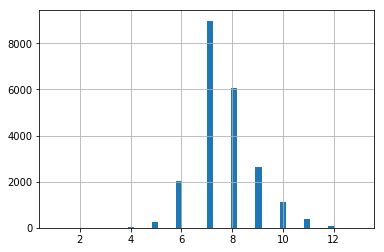

In [36]:
df['grade'].hist(bins=50);

## sqft_above

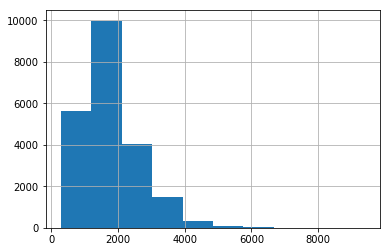

In [37]:
df['sqft_above'].hist();

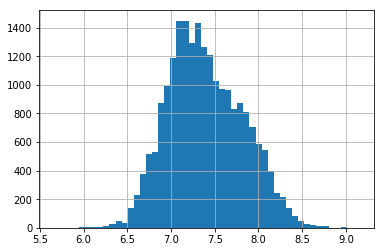

In [38]:
df['sqft_above_log'] = np.log( df['sqft_above'] )
df['sqft_above_log'].hist(bins=50);

## sqft_basement

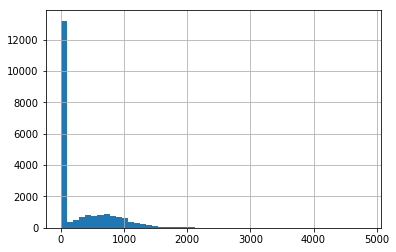

In [39]:
df['sqft_basement'].hist(bins=50);

In [40]:
df['sqft_basement'].value_counts(normalize=True)


0       0.607460
600     0.010135
700     0.010089
500     0.009904
800     0.009534
400     0.008515
1000    0.006896
900     0.006664
300     0.006572
200     0.004998
530     0.004952
480     0.004906
750     0.004859
450     0.004767
720     0.004720
620     0.004211
840     0.003934
580     0.003887
420     0.003749
1100    0.003702
860     0.003702
670     0.003656
780     0.003563
650     0.003517
550     0.003517
380     0.003517
850     0.003517
680     0.003471
240     0.003425
360     0.003378
          ...   
1525    0.000046
2580    0.000046
2500    0.000046
2180    0.000046
1990    0.000046
1284    0.000046
516     0.000046
276     0.000046
20      0.000046
915     0.000046
2850    0.000046
1798    0.000046
2310    0.000046
266     0.000046
2120    0.000046
1913    0.000046
1481    0.000046
3480    0.000046
3000    0.000046
2600    0.000046
2360    0.000046
1960    0.000046
295     0.000046
1880    0.000046
1816    0.000046
792     0.000046
2590    0.000046
935     0.0000

## yr_built

In [41]:
df['yr_built'].unique()

array([1955, 1951, 1933, 1965, 1987, 2001, 1995, 1963, 1960, 2003, 1942,
       1927, 1977, 1900, 1979, 1994, 1916, 1921, 1969, 1947, 1968, 1985,
       1941, 1915, 1909, 1948, 2005, 1929, 1981, 1930, 1904, 1996, 2000,
       1984, 2014, 1922, 1959, 1966, 1953, 1950, 2008, 1991, 1954, 1973,
       1925, 1989, 1972, 1986, 1956, 2002, 1992, 1964, 1952, 1961, 2006,
       1988, 1962, 1939, 1946, 1967, 1975, 1980, 1910, 1983, 1978, 1905,
       1971, 2010, 1945, 1924, 1990, 1914, 1926, 2004, 1923, 2007, 1976,
       1949, 1999, 1901, 1993, 1920, 1997, 1943, 1957, 1940, 1918, 1928,
       1974, 1911, 1936, 1937, 1982, 1908, 1931, 1998, 1913, 2013, 1907,
       1958, 2012, 1912, 2011, 1917, 1932, 1944, 1902, 2009, 1903, 1970,
       2015, 1934, 1938, 1919, 1906, 1935])

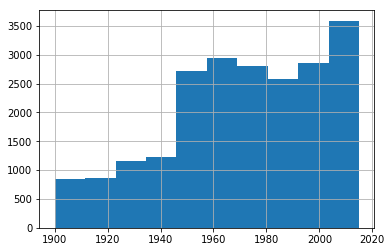

In [42]:
df['yr_built'].hist();

## yr_renovated

In [43]:
df['yr_renovated'].value_counts(normalize=True)

0       0.957747
2014    0.004211
2013    0.001712
2003    0.001666
2000    0.001620
2007    0.001620
2005    0.001620
2004    0.001203
1990    0.001157
2006    0.001111
2009    0.001018
1989    0.001018
2002    0.001018
1991    0.000926
2001    0.000879
1998    0.000879
1994    0.000879
1993    0.000879
1987    0.000833
1983    0.000833
1984    0.000833
2010    0.000833
2008    0.000833
1986    0.000787
1985    0.000787
1992    0.000787
1999    0.000740
2015    0.000740
1995    0.000740
1996    0.000694
          ...   
1975    0.000278
1978    0.000278
1981    0.000231
1964    0.000231
1965    0.000231
1958    0.000231
1973    0.000231
1969    0.000185
1972    0.000185
1960    0.000185
1963    0.000185
1956    0.000139
1945    0.000139
1974    0.000139
1953    0.000139
1955    0.000139
1976    0.000139
1957    0.000139
1962    0.000093
1950    0.000093
1967    0.000093
1946    0.000093
1971    0.000093
1940    0.000093
1954    0.000046
1934    0.000046
1959    0.000046
1951    0.0000

## zipcode

In [44]:
df['zipcode'].unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

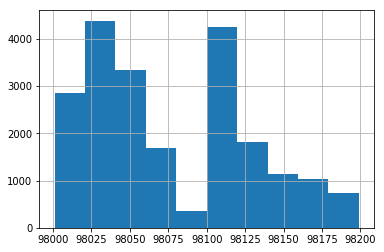

In [45]:
df['zipcode'].hist();

## Base line

In [46]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_log',
       'bathrooms_temp', 'sqft_living_log', 'sqft_lot_log', 'sqft_above_log'],
      dtype='object')

In [47]:
X = df[ ['sqft_living'] ].values
y = df['price'].values

cv_res = cross_val_score(DummyRegressor(strategy='mean'),X, y, scoring='neg_mean_absolute_error', cv=2 )
np.mean(cv_res), np.std(cv_res)

(-234204.85530322458, 817.3986774339137)

** Decided to choose `neg_mean_absolute_error`, because it treats error in a linear way as opposed to mean squared error, which raises to the square.**

In [48]:
corr = df.corr(method='spearman')

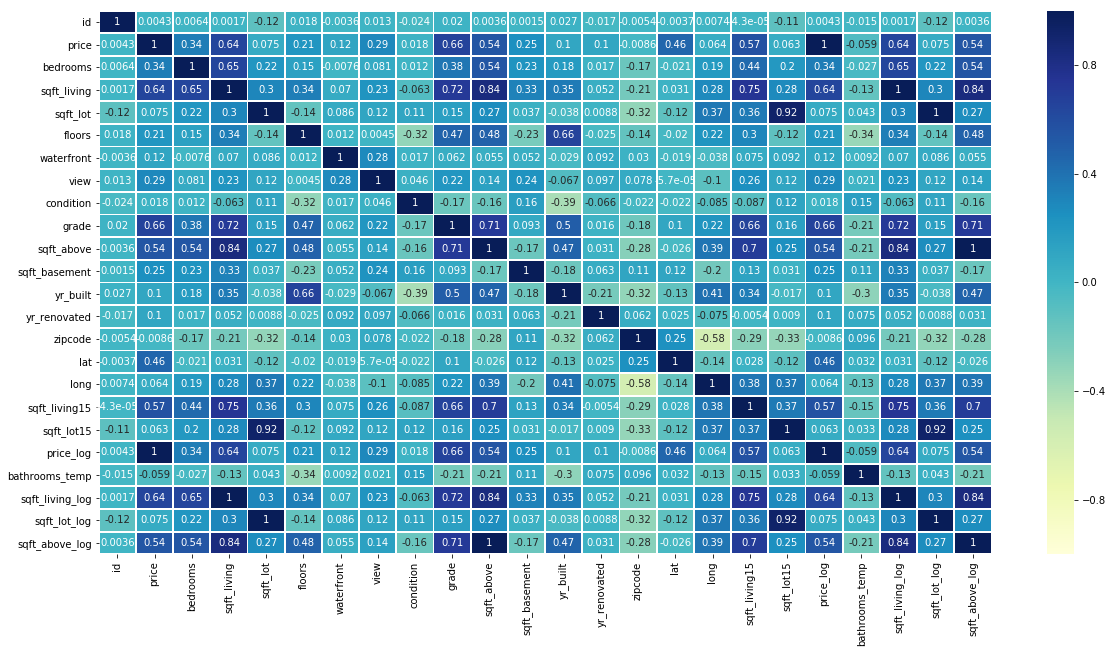

In [49]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(df.corr(method='spearman'), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

In [50]:
corr[ corr.price > 0.6 ].columns

Index(['id', 'price', 'bedrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price_log', 'bathrooms_temp',
       'sqft_living_log', 'sqft_lot_log', 'sqft_above_log'],
      dtype='object')

## Linear Model

In [51]:
def get_feats():
    return ['bedrooms', 'sqft_living', 'sqft_lot', 'floors',
           'waterfront', 'view', 'condition', 'grade', 'sqft_above',
           'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
           'sqft_living15', 'sqft_lot15', 'bathrooms_temp', 'sqft_living_log',
           'sqft_lot_log', 'sqft_above_log']
    
    
def get_X_y(df, tar_var='price'):
    feats = get_feats()
    
    return df[feats].values, df[tar_var]

In [52]:
X, y = get_X_y(df)

cv_res = cross_val_score(LinearRegression(),X, y, scoring='r2', cv=2 )
np.mean(cv_res), np.std(cv_res)

(0.7167180525547812, 0.006160956162950371)

In [53]:
X, y = get_X_y(df)

cv_res = cross_val_score(LinearRegression(),X, y, scoring='neg_mean_absolute_error', cv=2 )
np.mean(cv_res), np.std(cv_res)

(-122584.78393559858, 2605.914006301071)

In [54]:
def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    neg_mean_absolute_error_scorer = make_scorer(mean_absolute_error,
                                            greater_is_better=False)
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=neg_mean_absolute_error_scorer)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

** Learning curves  help in validation. Overfitting, underfitting is easier to notice. **


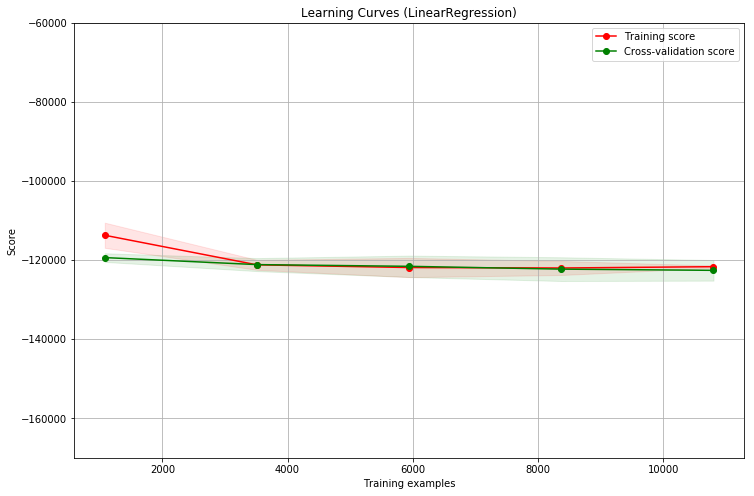

In [55]:
plt = plot_learning_curve(LinearRegression(), "Learning Curves (LinearRegression)", X, y, ylim=(-170000, -60000), cv=2)
plt.show()

## Feature Importance

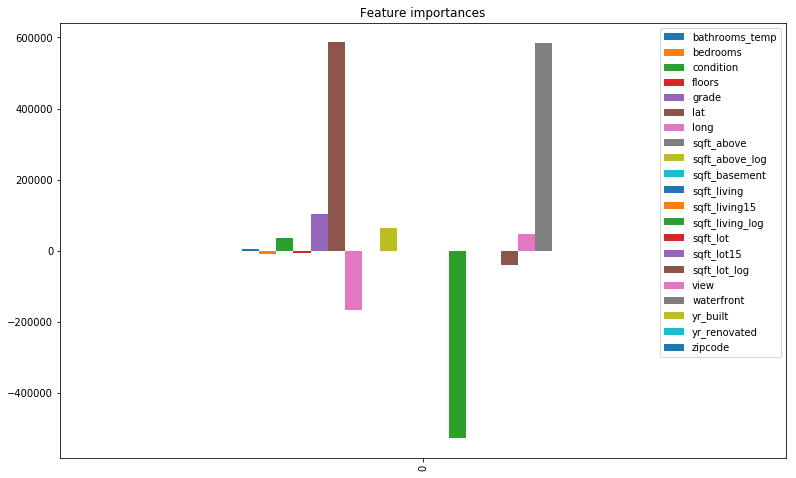

In [56]:
model = LinearRegression()
model.fit(X, y)

weights = list(model.coef_)

dict_feats = {label :weight for label, weight in zip(get_feats(), weights) }
feats = pd.DataFrame([dict_feats])
feats.plot(kind='bar', figsize=(13, 8), title="Feature importances");

## Decision Tree

In [57]:
X, y = get_X_y(df)

cv_res = cross_val_score(DecisionTreeRegressor(max_depth=5, random_state=2018),X, y, scoring='neg_mean_absolute_error', cv=2 )
np.mean(cv_res), np.std(cv_res)

(-119194.42371448771, 3084.3349185876286)

## Learning Curve

** Learning curves can help in validation of model. Overfitting or underfitting is easier to spot. **


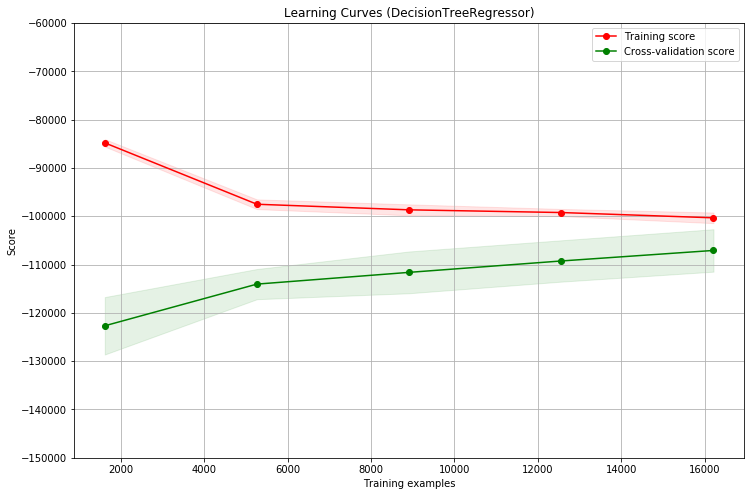

In [58]:
plt = plot_learning_curve(DecisionTreeRegressor(max_depth=6, random_state=2018), "Learning Curves (DecisionTreeRegressor)", X, y, ylim=(-150000, -60000), cv=4)
plt.show()

## Feature Importance

In [59]:
features = ['bedrooms', 'sqft_living', 'sqft_lot', 'floors',
           'waterfront', 'view', 'condition', 'grade', 'sqft_above',
           'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
           'sqft_living15', 'sqft_lot15', 'bathrooms_temp', 'sqft_living_log',
           'sqft_lot_log', 'sqft_above_log']

In [60]:
def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

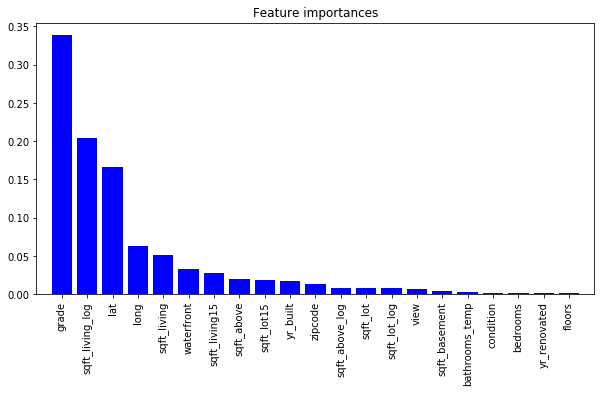

In [61]:
model = DecisionTreeRegressor()
model.fit(X, y)

draw_feature_importances(model, features)

## Random Forest

In [62]:
X, y = get_X_y(df)

cv_res = cross_val_score(RandomForestRegressor(max_depth=5, n_estimators=50, random_state=2018),X, y, scoring='r2', cv=3 )
np.mean(cv_res), np.std(cv_res)

(0.7683427156478442, 0.011523992056936277)

In [63]:
X, y = get_X_y(df)

cv_res = cross_val_score(RandomForestRegressor(max_depth=5, n_estimators=50, random_state=2018),X, y, scoring='neg_mean_absolute_error', cv=3 )
np.mean(cv_res), np.std(cv_res)

(-103844.1434690458, 3920.9471587869584)

### Feature Importance

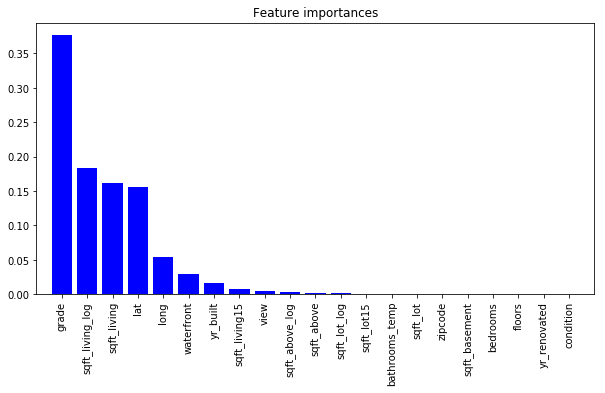

In [64]:
model = RandomForestRegressor(max_depth=5, n_estimators=50, random_state=2018)
model.fit(X, y)

draw_feature_importances(model, features)

### Learning Curve

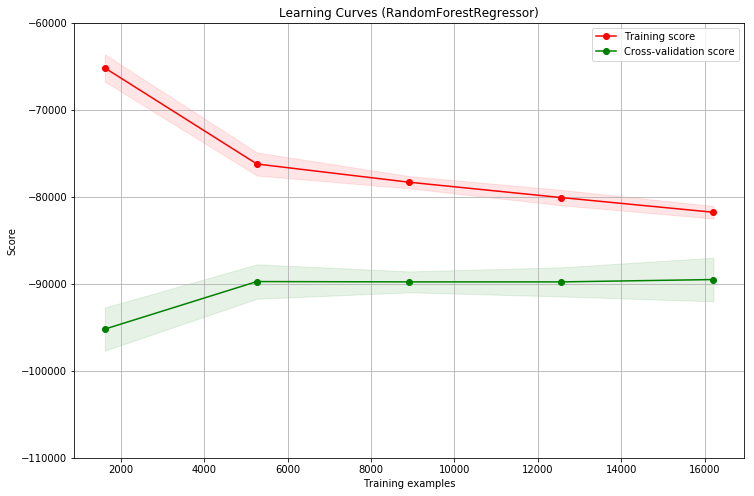

In [65]:
plt = plot_learning_curve(RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=4, random_state=2018), "Learning Curves (RandomForestRegressor)", X, y, ylim=(-110000, -60000), cv=4 )
plt.show()

## XGBoost

In [66]:
features = get_feats()
X, y = get_X_y(df)

cv_res = cross_val_score(xgb.XGBRegressor(max_depth=3, n_estimators=100, seed=2018, n_jobs=4),X, y, scoring='neg_mean_absolute_error', cv=3 )
np.mean(cv_res), np.std(cv_res)

(-78445.27060800527, 1970.9705126323063)

## Learning Curve

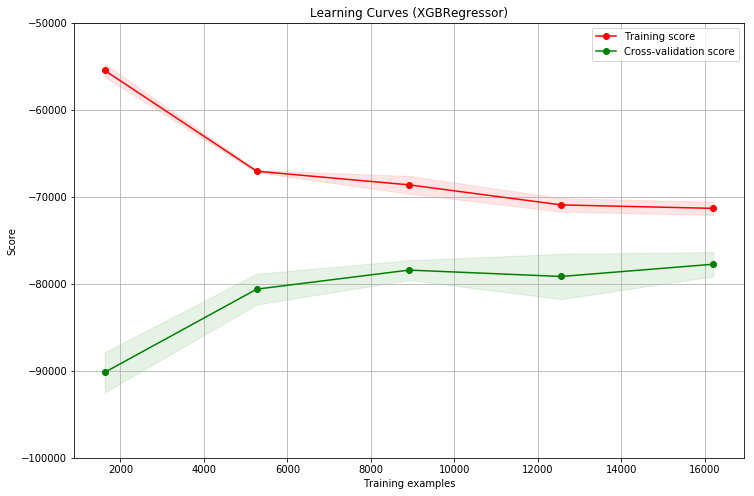

In [67]:
xgb_params = {
    'max_depth': 3, 
    'n_estimators': 100, 
    'learning_rate': 0.2,
    'seed': 2018, 
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'n_jobs': 4,
    
}

plt = plot_learning_curve(xgb.XGBRegressor(**xgb_params), "Learning Curves (XGBRegressor)", X, y, ylim=(-100000, -50000), cv=4 )
plt.show()

## Feature Importance

In [68]:
model = xgb.XGBRegressor(**xgb_params)
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2018,
       silent=True, subsample=0.5)

In [69]:
def xgb_draw_importance_features(model, df, importance_type='gain'):

    fscore = model.get_booster().get_score(importance_type=importance_type) #cover, gain, weight
    maps_name = dict([ ("f{0}".format(i), col) for i, col in enumerate(df.columns)])

    impdf = pd.DataFrame([ {'feature': maps_name[k], 'importance': fscore[k]} for k in fscore ])
    impdf = impdf.sort_values(by='importance', ascending=False).reset_index(drop=True)
    impdf['importance'] /= impdf['importance'].sum()
    impdf.index = impdf['feature']

    impdf.plot(kind='bar', title='{0} - Importance Features'.format(importance_type.title()), figsize=(6, 5))

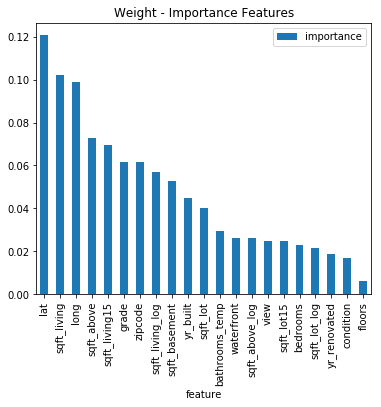

In [70]:
xgb_draw_importance_features(model, df[features], importance_type='weight')

** `weight` indicates how often certain feature occures. **

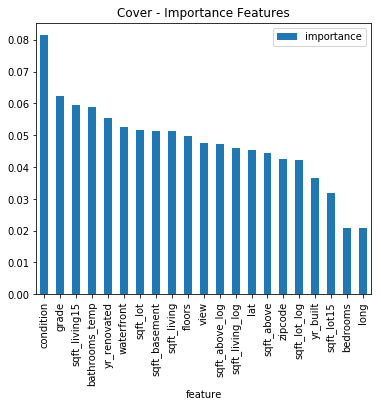

In [71]:
xgb_draw_importance_features(model, df[features], importance_type='cover')

** Algorithm notice different things. E.g. cover indicates which feature is covering majority of features. **

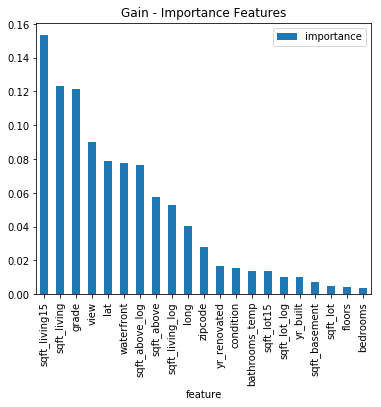

In [72]:
xgb_draw_importance_features(model, df[features], importance_type='gain')

- ** `gain` - how feature helped to mitigate set, spliting it into two subsets. **
- ** the task here is to decrease entropy. **
- ** when talking about `feature importance`, I probably should focus on `gain`, because it indicates how this feature is able to split set into two subsets, to organize data in them. **

** Same model, three charts. Depends what it is watching for, we get different results. In a shortcut I'm looking at all three charts and notice top5-7. **

** Looking for a case when, there is one feature which is able to split set into two subsets. These subsets have to be clear - without mixture. **

In [73]:
#!touch featmap.txt
model.get_booster().dump_model('model.xgb', 'featmap.txt')
!cat featmap.txt

## XGB Trees Visualization

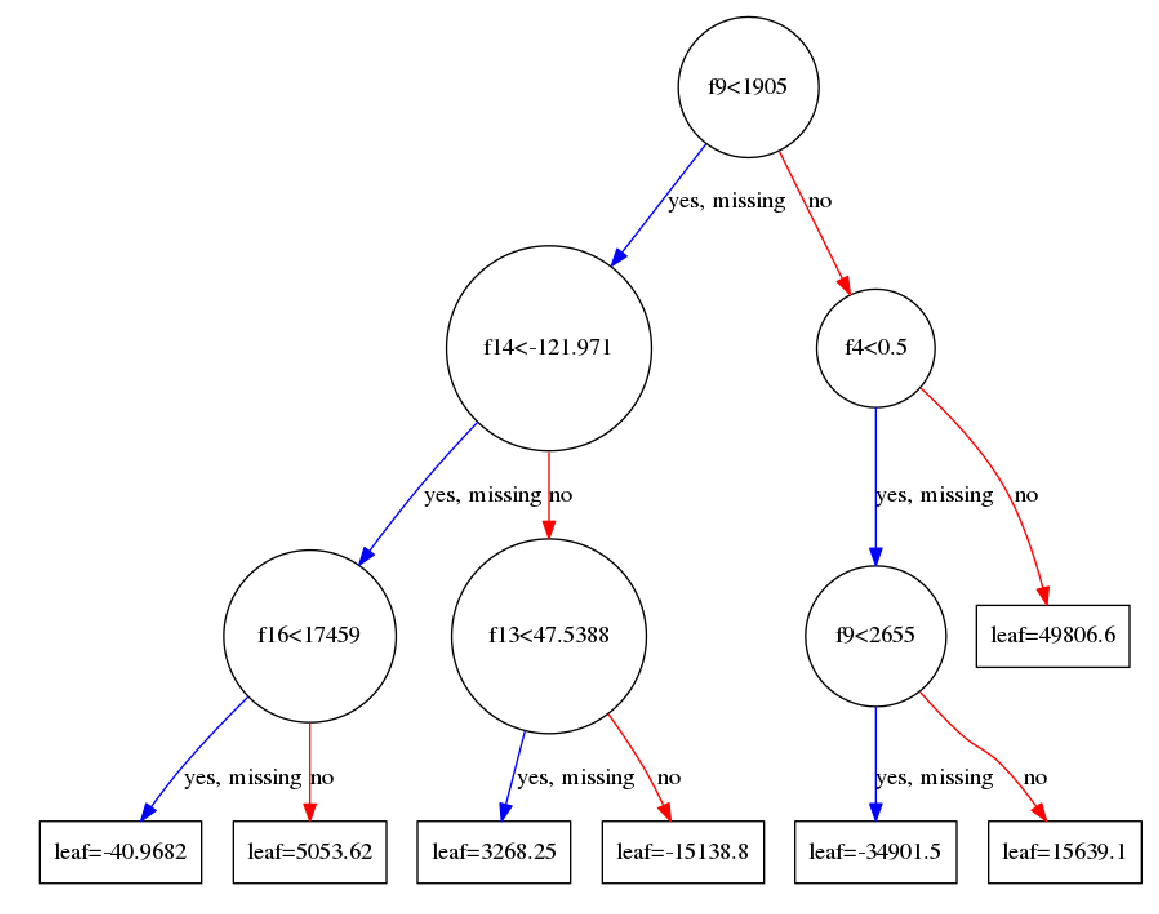

In [74]:
plot_tree(model, num_trees=69)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

## Difference in building a model  with or without `logarithm transformation`

** I want to compare if it's going to help acheive better score. **

In [75]:
def get_features():
    return ['lat', 'sqft_living', 'long', 'sqft_above', 'yr_built', 'sqft_basement', 'condition', 'yr_renovated',
'waterfront', 'sqft_living_log', 'grade', 'view']

In [76]:
offset_log = 1
df['price_log'] = np.log2( df['price'] + offset_log )

In [77]:
feats = get_features()
X     = df[feats].values
y     = df['price'].values

In [78]:
def run_model(model, X, y, offset_log = 1, folds=4, fun_score=mean_absolute_error, use_log=True):
    cv = KFold(n_splits=folds, shuffle=True, random_state=2018).split(X)
    
    scores = []
    for train_idx, test_idx in cv:
        y_train = np.log2( y[train_idx] + offset_log) if use_log else y[train_idx]
        model.fit(X[train_idx], y_train)
        
        y_pred = model.predict(X[test_idx])
        if use_log:
            y_pred = np.exp2(y_pred) - offset_log
        
        score = fun_score(y[test_idx], y_pred)
        scores.append(score)
        
    return np.mean(scores), np.std(scores)

In [79]:
run_model(LinearRegression(), X, y, use_log=False)

(123848.1530149937, 1528.0858338713376)

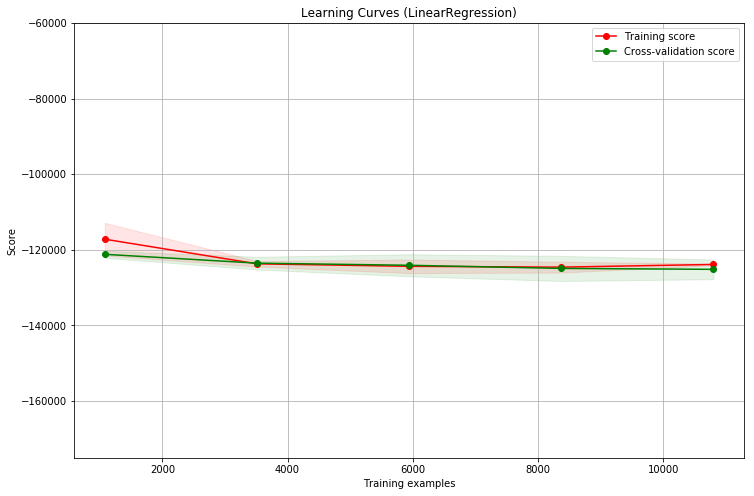

In [80]:
plt = plot_learning_curve(LinearRegression(), "Learning Curves (LinearRegression)", X, y, ylim=(-175000, -60000), cv=2 )
plt.show()

In [81]:
run_model(LinearRegression(), X, y, use_log=True)

(112699.67404655163, 1985.0222227779816)

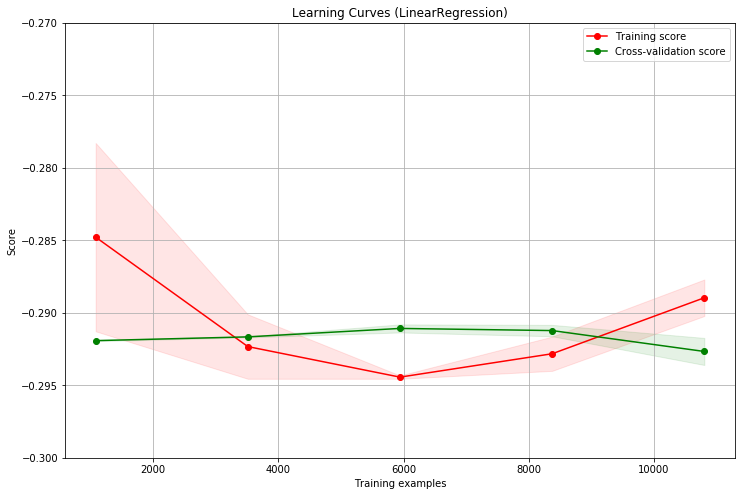

In [82]:
plt = plot_learning_curve(LinearRegression(), "Learning Curves (LinearRegression)", X, np.log2(y + 1), ylim=(-0.3, -0.27), cv=2 )
plt.show()

** `Underfitting` **

## Decision Tree

In [83]:
run_model(DecisionTreeRegressor(max_depth=7, random_state=2018), X, y, use_log=False)

(100795.3764657799, 1707.0219294012581)

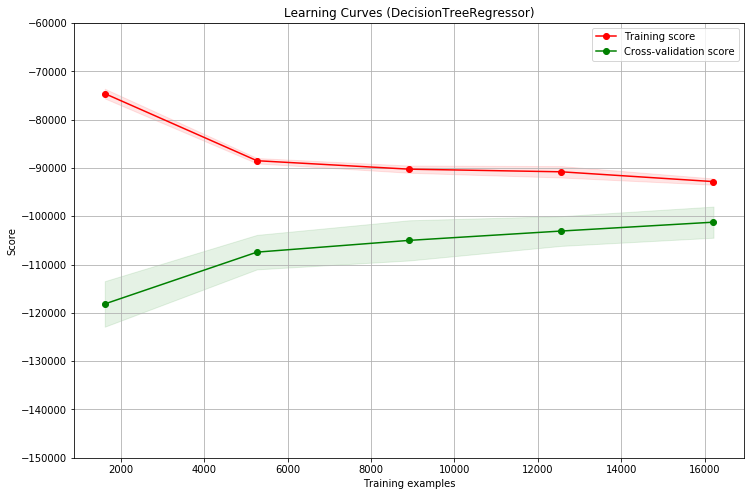

In [84]:
plt = plot_learning_curve(DecisionTreeRegressor(max_depth=7, random_state=2018), "Learning Curves (DecisionTreeRegressor)", X, y, ylim=(-150000, -60000), cv=4)
plt.show()

In [85]:
run_model(DecisionTreeRegressor(max_depth=7, random_state=2018), X, y, use_log=True)

(98780.61460865467, 797.4000637104058)

## Random Forest

In [86]:
run_model(RandomForestRegressor(max_depth=7, n_estimators=50, random_state=2018), X, y, use_log=False)

(89297.77410155446, 1430.222687496393)

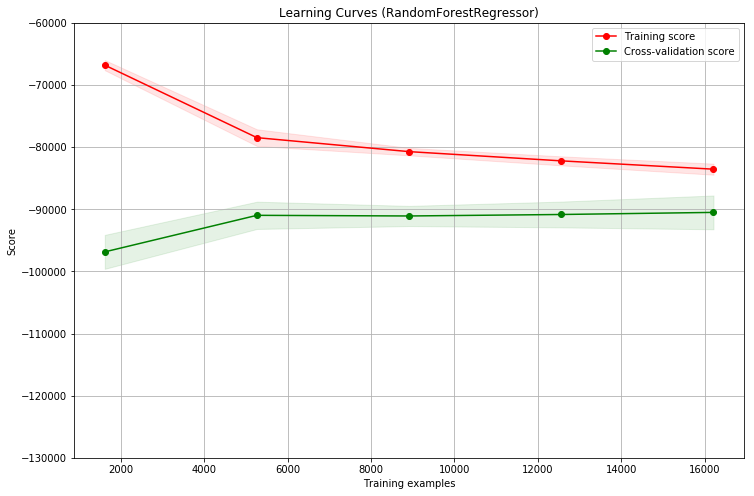

In [87]:
plt = plot_learning_curve(RandomForestRegressor(max_depth=7, n_estimators=50, random_state=2018), "Learning Curves (RandomForestRegressor)", X, y, ylim=(-130000, -60000), cv=4 )
plt.show()

In [88]:
run_model(RandomForestRegressor(max_depth=7, n_estimators=50, random_state=2018), X, y, use_log=True)

(89095.08197658982, 1576.055747223593)

## Xgboost

In [89]:
run_model(xgb.XGBRegressor(max_depth=6, n_estimators=100, random_state=2018, seed=2018), X, y, use_log=False)

(70627.13170252337, 1423.7141597526986)

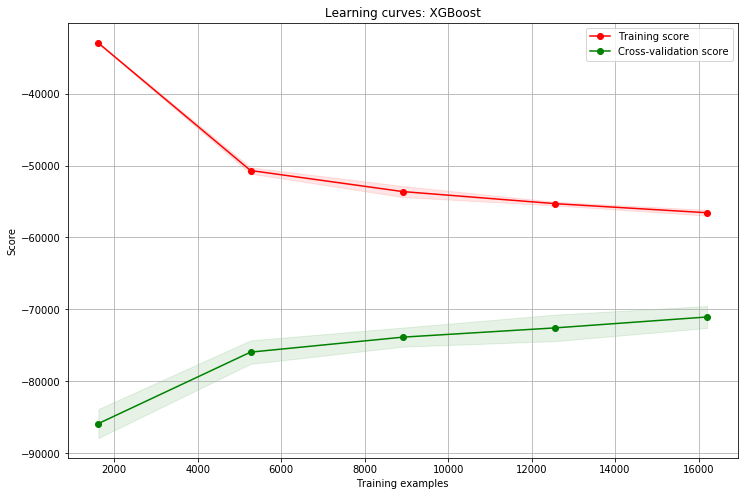

In [92]:
plt = plot_learning_curve(xgb.XGBRegressor(max_depth=6, n_estimators=100, random_state=2018, seed=2018), "Learning curves: XGBoost", X, y, cv=4)
plt.show()

In [93]:
run_model(xgb.XGBRegressor(max_depth=6, n_estimators=100, random_state=2018, seed=2018), X, y, use_log=True)

(68647.14959086334, 1748.766781655639)

## Feature Selection

** I'm assuming, that in case of house price prediction the key will be to select right features. **

In [94]:
df['total_sqft'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']

** Is there a correlation between price & zipcode? **

In [95]:
df[ ['price', 'zipcode']].groupby(['price']).median()

,zipcode
price,
75000.0,98022.0
78000.0,98168.0
80000.0,98014.0
81000.0,98168.0
82000.0,98146.0
82500.0,98168.0
83000.0,98168.0
84000.0,98168.0
85000.0,98032.0


In [96]:
df[ ['price', 'zipcode']].groupby(['price']).mean()

,zipcode
price,
75000.0,98022.000000
78000.0,98168.000000
80000.0,98014.000000
81000.0,98168.000000
82000.0,98146.000000
82500.0,98168.000000
83000.0,98168.000000
84000.0,98168.000000
85000.0,98032.000000


## Relationship between numerical variables

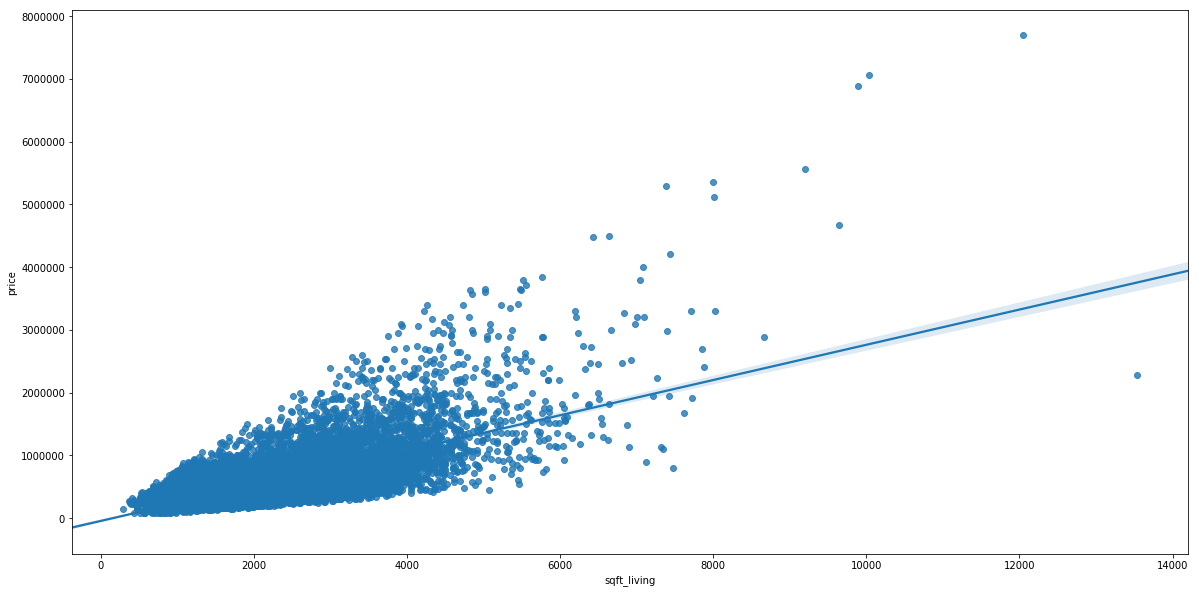

In [97]:
ax = sns.regplot(x="sqft_living", y="price", data=df)

** linear relationship between `sqft_living` & `price` **

** We can see at the bottom right one with large sqft_living that are of a medium price. This value is oultlier. Therefore, we can safely delete it. **

In [98]:
df = df[ df['sqft_living'] < 13000 ]

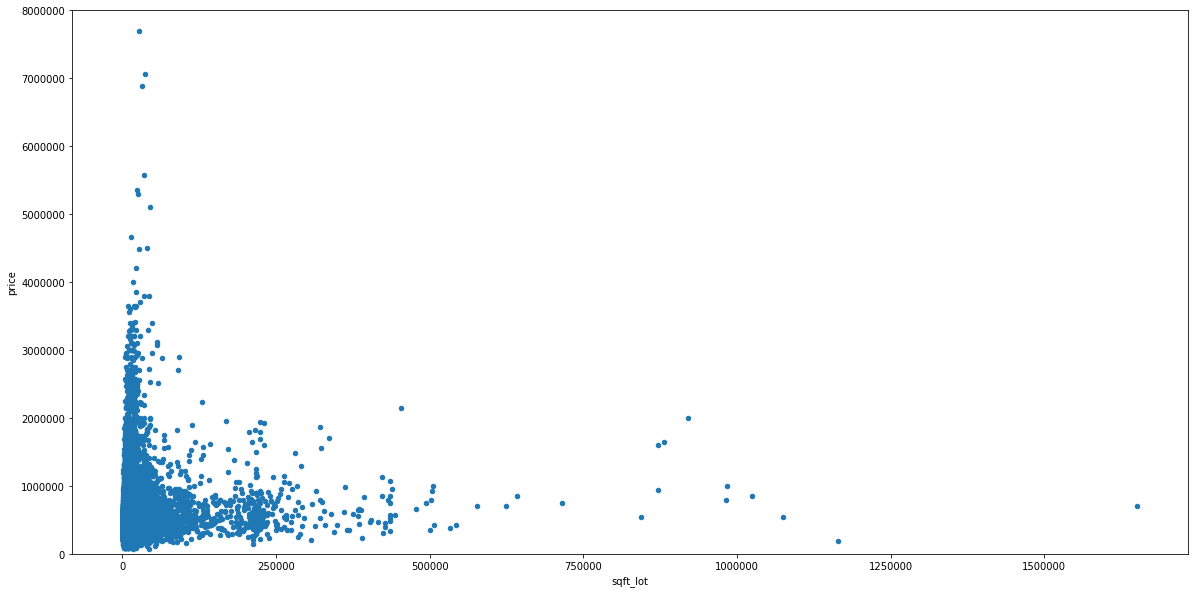

In [99]:
var = 'sqft_lot'
data = pd.concat([df['price'], df[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(1,8000000));

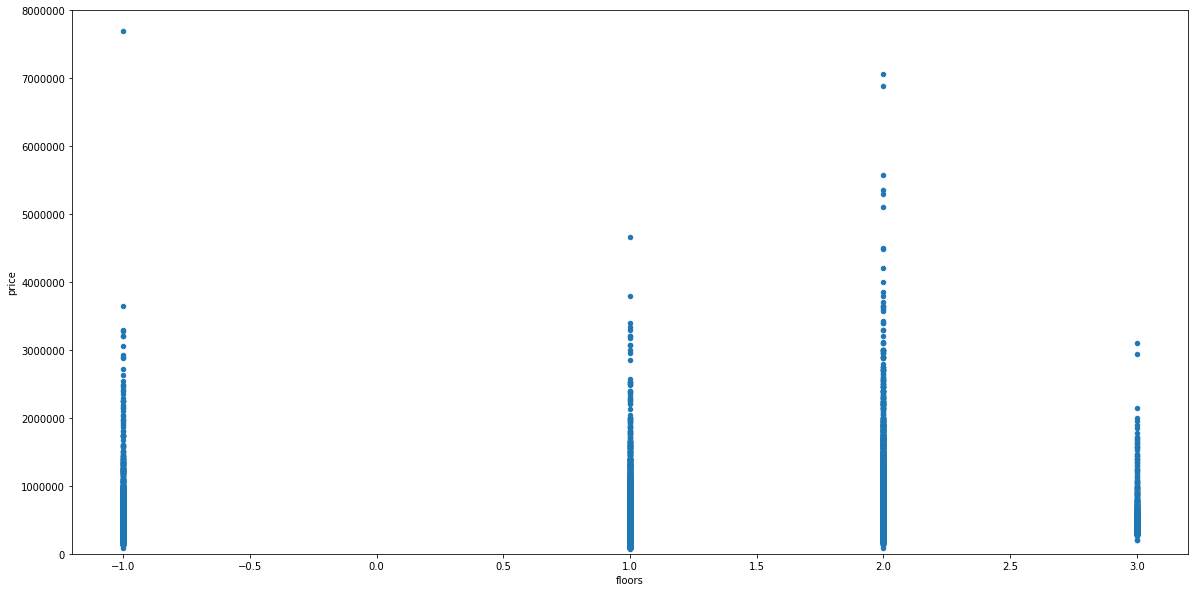

In [100]:
var = 'floors'
data = pd.concat([df['price'], df[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(1,8000000));

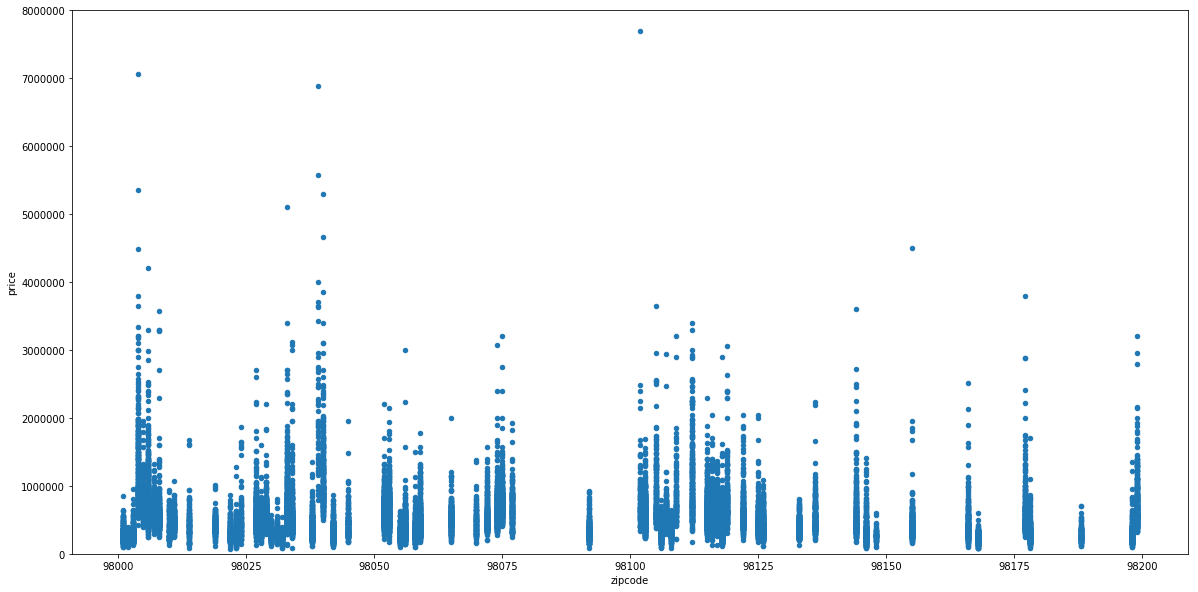

In [101]:
var = 'zipcode'
data = pd.concat([df['price'], df[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(1,8000000));

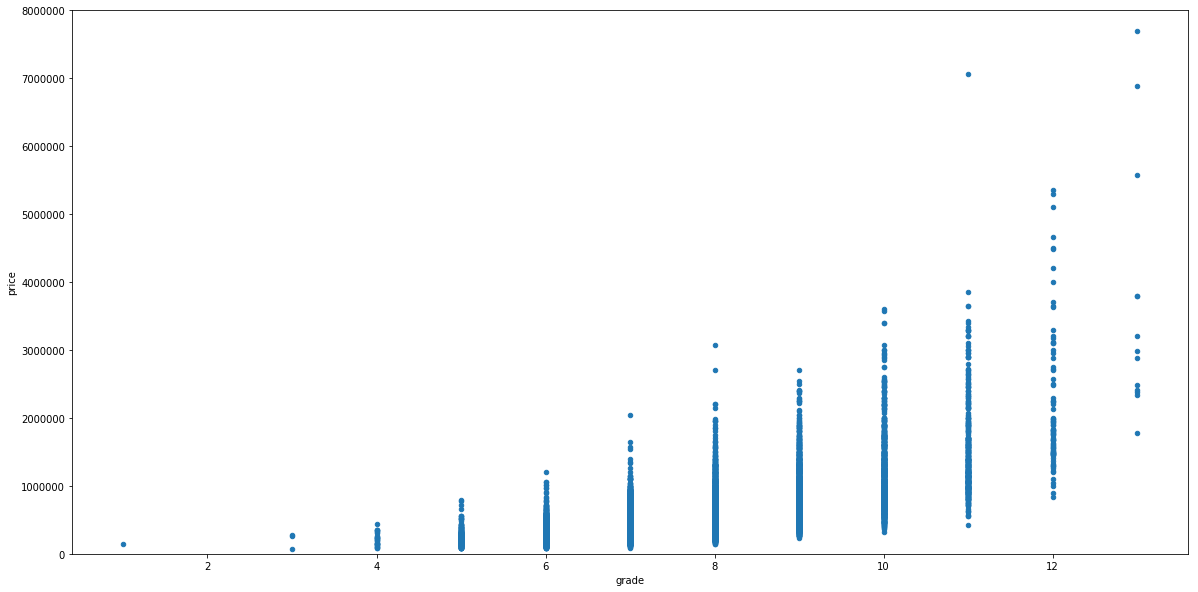

In [102]:
var = 'grade'
data = pd.concat([df['price'], df[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(1,8000000));

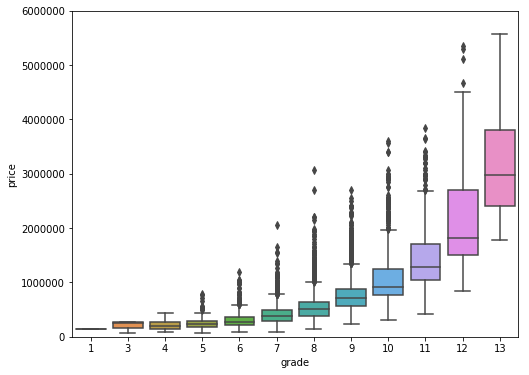

In [103]:
var = 'grade'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=6000000);

** `grade` seems to be related with `price`. The box plot shows prices increase with the overall quality. **


## Outliers

In [104]:
saleprice_scaled = StandardScaler().fit_transform(df['price'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.26709666]
 [-1.25892123]
 [-1.25347095]
 [-1.2507458 ]
 [-1.24802066]
 [-1.24665809]
 [-1.24529552]
 [-1.24257037]
 [-1.23984523]
 [-1.23984523]]

outer range (high) of the distribution:
[[10.76168584]
 [10.79166242]
 [11.24948649]
 [12.45617994]
 [12.97177705]
 [13.10803422]
 [13.70756574]
 [17.29112917]
 [17.77484211]
 [19.51212096]]


- Low range values are similar and not too far from 0.
- High range values are far from 0 and the 7.something values are really out of range.

For now, we'll not consider any of these values as an outlier but we should be careful with those three 17.28, 17.65, 19.5 values.

## All features

In [105]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [106]:
feats = ['bedrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 
       'bathrooms_temp', 'sqft_living_log', 'sqft_lot_log', 'sqft_above_log',
       'total_sqft', 'year', 'month', 'day']

In [107]:
X = df[feats].values
y = df['price'].values

xgb_params = {
    'max_depth': 6, 
    'n_estimators': 100, 
    'learning_rate': 0.2,
    'seed': 2018, 
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'n_jobs': 4,    
}

run_model(xgb.XGBRegressor(**xgb_params), X, y, use_log=True)

(65978.8099436186, 1021.2985562201603)

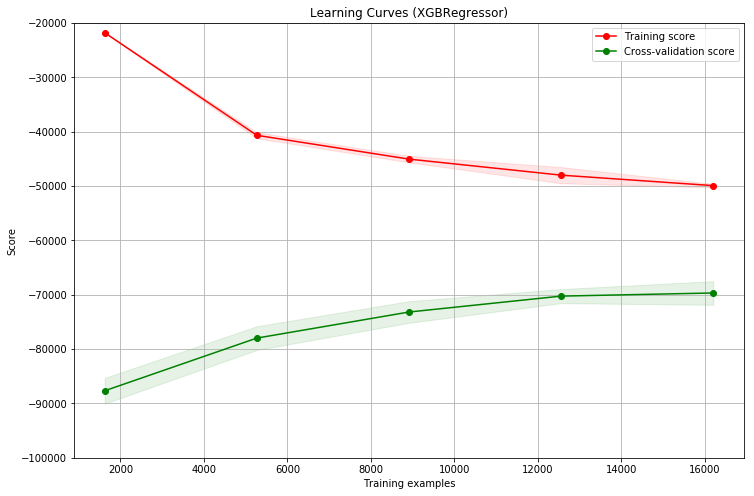

In [108]:
plt = plot_learning_curve(xgb.XGBRegressor(**xgb_params), "Learning Curves (XGBRegressor)", X, y, ylim=(-100000, -20000), cv=4 )
plt.show()

In [109]:
model = xgb.XGBRegressor(**xgb_params)
model.fit(X, y)

fscore = model.get_booster().get_score(importance_type='gain')

In [110]:
feats_score = { feats[ int(x[1:]) ]: x_value for x, x_value in fscore.items() }    
sorted_feats = sorted(feats_score, key=lambda x: x[1])

sorted_feats

['waterfront',
 'lat',
 'bathrooms_temp',
 'day',
 'bedrooms',
 'year',
 'view',
 'zipcode',
 'floors',
 'total_sqft',
 'month',
 'long',
 'condition',
 'sqft_living_log',
 'sqft_lot',
 'sqft_living15',
 'sqft_basement',
 'sqft_above',
 'sqft_lot15',
 'sqft_living',
 'sqft_lot_log',
 'sqft_above_log',
 'yr_built',
 'grade',
 'yr_renovated']

In [111]:
y = df['price'].values
results = []

for it in tqdm(range(len(sorted_feats))):
    cur_feats = sorted_feats[:it+1]

    X = df[cur_feats].values
    
    result = run_model(xgb.XGBRegressor(**xgb_params), X, y, use_log=True)
    results.append(result)


 40%|████      | 10/25 [00:09<00:13,  1.09it/s]/home/zubi/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
 68%|██████▊   | 17/25 [00:18<00:08,  1.10s/it]/home/zubi/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
 92%|█████████▏| 23/25 [00:29<00:02,  1.28s/it]/home/zubi/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


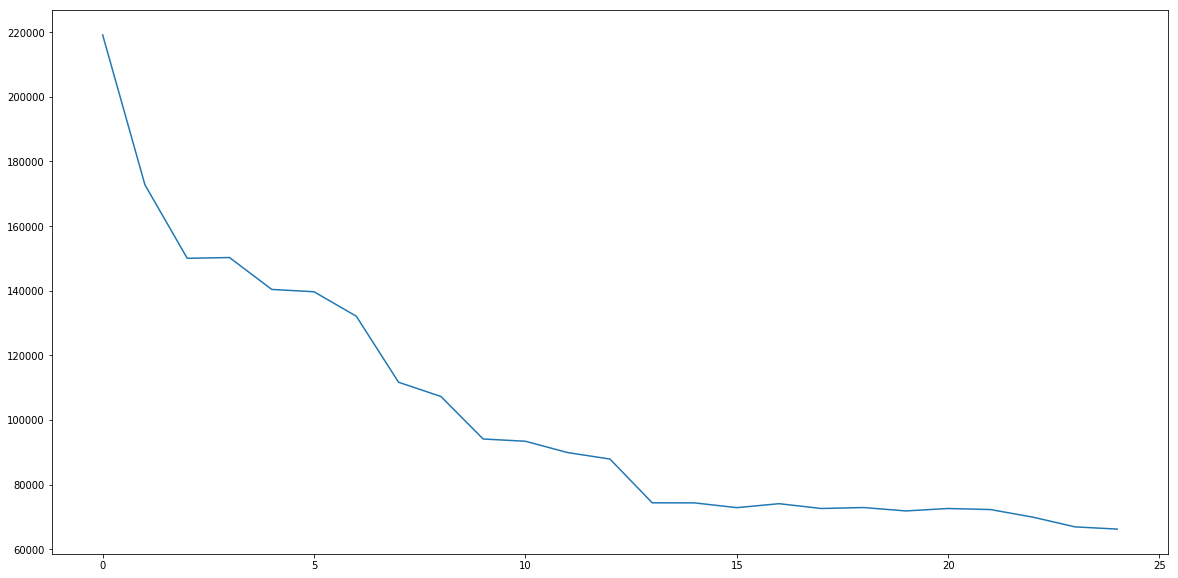

In [112]:
x = range(len(results))
y = [r[0] for r in results]

plt.plot(x, y);

In [113]:
df.groupby('grade').agg(np.median)['price']

grade
1      142000.0
3      262000.0
4      205000.0
5      228700.0
6      275276.5
7      375000.0
8      510000.0
9      720000.0
10     914327.0
11    1284000.0
12    1815000.0
13    2983000.0
Name: price, dtype: float64

In [114]:
xgb_params_level1 = {
 'colsample_bytree': 0.5,
 'learning_rate': 0.2,
 'max_depth': 6,
 'n_estimators': 200,
 'n_jobs': 4,
 'seed': 2018,
 'subsample': 0.5}

In [115]:
X = df[feats].values
y = df['price'].values

model = xgb.XGBRegressor(**xgb_params_level1)
model.fit(X, y)

leaves = model.apply(X)

In [116]:
xgb_params_level2 = {
 'colsample_bytree': 0.5,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 200,
 'n_jobs': 4,
 'seed': 2018,
 'subsample': 0.5
}

run_model(xgb.XGBRegressor(**xgb_params_level2), leaves, y, fun_score=mean_absolute_error, use_log=False)

(69002.19430597387, 1475.7817274104473)

In [117]:
run_model(xgb.XGBRegressor(**xgb_params_level2), leaves, y, fun_score=mean_absolute_error, use_log=True)

(66034.77383002473, 1236.274862531155)

In [118]:
model_level2 = xgb.XGBRegressor(**xgb_params)
model_level2.fit(leaves, y)
y_pred = model_level2.predict(leaves)

print(mean_absolute_error(y, y_pred))
print(r2_score(y, y_pred))

51653.09071315141
0.9600783983748882


In [119]:
group_feats = [ [], [], [] ]
for it,feat in enumerate(sorted_feats):
    group_feats[it % 3].append(feat)

In [120]:
fscores = []
for curr_feat in group_feats:
    X = df[curr_feat].values

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X, y)
    fscores.append( (curr_feat, model.get_booster().get_score(importance_type='weight')) ) 

In [121]:
fscores

[(['waterfront',
   'day',
   'view',
   'total_sqft',
   'condition',
   'sqft_living15',
   'sqft_lot15',
   'sqft_above_log',
   'yr_renovated'],
  {'f0': 57,
   'f1': 495,
   'f2': 240,
   'f3': 1126,
   'f4': 144,
   'f5': 614,
   'f6': 847,
   'f7': 646,
   'f8': 225}),
 (['lat',
   'bedrooms',
   'zipcode',
   'month',
   'sqft_living_log',
   'sqft_basement',
   'sqft_living',
   'yr_built'],
  {'f0': 898,
   'f1': 261,
   'f2': 545,
   'f3': 349,
   'f4': 867,
   'f5': 495,
   'f6': 225,
   'f7': 528}),
 (['bathrooms_temp',
   'year',
   'floors',
   'long',
   'sqft_lot',
   'sqft_above',
   'sqft_lot_log',
   'grade'],
  {'f0': 331,
   'f1': 97,
   'f2': 178,
   'f3': 1092,
   'f4': 1103,
   'f5': 712,
   'f6': 336,
   'f7': 308})]

## Using hyperopt to find better params

In [122]:
def objective(space):
    X = df[feats].values
    y = df['price'].values

    xgb_params_level1 = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': 0.2,
        'subsample': space['subsample'],
        'seed': int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': int(space['n_estimators']),
        'n_jobs': 4
    }

    model = xgb.XGBRegressor(**xgb_params_level1)
    model.fit(X, y)

    leaves = model.apply(X)

    xgb_params_level2 = {
     'colsample_bytree': 0.5,
     'learning_rate': 0.2,
     'max_depth': 3,
     'n_estimators': 100,
     'n_jobs': 4,
     'seed': 2018,
     'subsample': 0.5}

    means_score, std_score = run_model(xgb.XGBRegressor(**xgb_params_level2), leaves, y, fun_score=mean_absolute_error, use_log=True)

    print(means_score, std_score, xgb_params_level1)


    return{'loss':means_score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 3, 8, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.3, 0.7),
    'learning_rate': hp.uniform ('x_learning_rate', 0.1, 0.3),
    'n_estimators': hp.quniform ('x_n_estimators', 50, 300, 10),
    'subsample': hp.uniform ('x_subsample', 0.3, 0.7),
    'seed': hp.quniform ('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 0.1),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.9, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best_params)

69064.69282868585 886.8009171170904 {'max_depth': 4, 'colsample_bytree': 0.3943046909700146, 'learning_rate': 0.2, 'subsample': 0.6529156541473883, 'seed': 9200, 'min_child_weight': 7, 'reg_alpha': 1.052143486320662, 'reg_lambda': 0.9013429334319745, 'n_estimators': 100, 'n_jobs': 4}
69696.74223411836 1132.4744407087248 {'max_depth': 3, 'colsample_bytree': 0.3529212831314622, 'learning_rate': 0.2, 'subsample': 0.6998714647558976, 'seed': 9450, 'min_child_weight': 8, 'reg_alpha': 1.0529830031611103, 'reg_lambda': 0.9019968429460324, 'n_estimators': 90, 'n_jobs': 4}
69286.23642515915 773.8025716883578 {'max_depth': 7, 'colsample_bytree': 0.692105256126739, 'learning_rate': 0.2, 'subsample': 0.4067528668336752, 'seed': 2250, 'min_child_weight': 2, 'reg_alpha': 1.001342067933275, 'reg_lambda': 0.9029520594040499, 'n_estimators': 270, 'n_jobs': 4}
72165.37494621694 947.9215852467132 {'max_depth': 3, 'colsample_bytree': 0.3129990913481434, 'learning_rate': 0.2, 'subsample': 0.686280435644911

In [123]:
xgb_params_ho = {
 'colsample_bytree': 0.521,
 'learning_rate': 0.223,
 'max_depth': 6,
 'n_estimators': 160,
 'min_child_weight': 6,
 'reg_alpha': 1.047,
 'reg_lambda': 0.942,
 'seed': 3700,
 'subsample': 0.694
}

run_model(xgb.XGBRegressor(**xgb_params_ho), leaves, y, fun_score=mean_absolute_error, use_log=False)

(64856.25795658464, 1151.0154986445307)

In [124]:
run_model(xgb.XGBRegressor(**xgb_params_ho), leaves, y, fun_score=mean_absolute_error, use_log=True)

(62816.82266056782, 822.1588336104953)

In [128]:
model_ho = xgb.XGBRegressor(**xgb_params_ho)
model_ho.fit(leaves, y)
y_pred = model_ho.predict(leaves)

print(mean_absolute_error(y, y_pred))
print(r2_score(y, y_pred))

44712.596884473205
0.9714447925604602


## Next Steps

## Feature Importance with `xgbfir` ##

In [129]:
xgbfir.saveXgbFI(model,feature_names=features, OutputXlsxFile='house_fi.xlsx')

## Dependency between three features

In [130]:
pd.read_excel('house_fi.xlsx', 'Interaction Depth 2')

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,view|view|view,2136159101320000,136,41.923745,0.308263,1.570705e+13,5.530142e+14,1,8,1,5,8,1,4.000000,55.941176,3.713235
1,floors|view|view,2058505487770000,139,17.350102,0.124821,1.480939e+13,3.625108e+14,2,7,5,30,10,3,9.500000,52.086331,3.920863
2,grade|grade|grade,1668992400000000,9,2.724346,0.302705,1.854436e+14,4.875253e+14,3,67,39,6,1,2,19.666667,4.777778,2.111111
3,floors|grade|grade,1006981842000000,43,4.322977,0.100534,2.341818e+13,9.865599e+13,4,26,25,35,4,5,16.500000,39.441860,3.232558
4,floors|floors|waterfront,683251849870000,240,14.270738,0.059461,2.846883e+12,5.629715e+13,5,1,6,61,32,10,19.166667,36.183333,4.341667
5,grade|grade|sqft_lot,648750023900000,10,2.305192,0.230519,6.487500e+13,1.462416e+14,6,64,41,12,2,4,21.500000,16.300000,2.800000
6,view|view|waterfront,622893058530000,150,13.793957,0.091960,4.152620e+12,7.303792e+13,7,5,8,41,26,7,15.666667,55.433333,4.126667
7,sqft_lot|view|view,537199256800000,31,2.587451,0.083466,1.732901e+13,6.937225e+13,8,36,40,47,7,9,24.500000,40.419355,3.774194
8,floors|floors|view,431833547299000,141,3.470507,0.024614,3.062649e+12,5.593412e+12,9,6,31,84,31,36,32.833333,55.567376,4.255319
9,floors|view|waterfront,382529605550000,74,4.555264,0.061558,5.169319e+12,2.635102e+13,10,16,23,58,22,13,23.666667,38.229730,4.459459


** `xbgfir` is a tool, which extracts info from the insights of XGBoost and writes it into table (excel file). **

    xgbfir provides us more info, than common feature importances :

- Gain Rank
- FScore Rank
- Avg wFScore Rank
- Avg Gain Rank
- Expected Gain Rank
- Average Rank
    
   ** Depends on the raiting, the scores may vary. **

** This framework helps to recognize important features in feature selection/engineering process. Pointed out features could be joined, divided or multiplied. **

## Save model on a disc

`joblib.dump()`

## Flask

** Building and verification of a model is very important, but the key is enable `"the world"` to see it. For that I could use `Flask`. It's easy and functional framework. ** 

## Conclusion

** `MAE` - in this solution is my success metric, because it's more comfortable with outliers and thus it's not trying at any cost to minimalize a certain aberration. I was also considering `RMSE` because it has first and second derivative. `RMSE` doesn't cope too good with outliers. Goes all-in, just to minimalize aberration. **

- [open door](https://www.opendoor.com/). This startup has model, which is able to estimate quickly the price of a flat at any given time with just information, about location and buy it in few days (thereby seller doesn't have to worry and wait for a buyer, it's guaranteed, that the property will be bought).

- In Poland we have two projects that I'm familiar with, which estimates the price considering few params:
1. [Urban.one](https://urban.one/)
2. [Cenatorium](https://cenatorium.pl/)

When it comes to business, I have few ideas:
1. It is possible to make price prediction, to find cheaper (more expensive propeties). The number of advertisements is usually far greater than the amount of free time we have for searching. Our model could be wise filter, which finds interesting (e.g. cheaper) properties. 

2. I could think of a model which will suggest how much a property is going to cost. Fill it with info, that I want a flat, which is that much square metres big, on that floor and in a certain neighbourhood. That model could suggest the price. 

3. Real estate agents are still struggling with preparing advertisements, so we can try finding reliance on how properties, which cost more than they should (but are attractive - have got a great deal of views) looks like. 

4. We are able to prepare assistent, which is awaiting certain guides (expectations), then tells, if you are going to buy flat one floor above or without garage - you are going to save 20% or pay only 5% extra and you will get garage and balcony :)